In [1]:
from collections import defaultdict

class Graph:
    def __init__(self, graph):
        self.graph = graph
        self.ROW = len(graph)

    def bfs(self, s, t, parent):
        visited = [False] * self.ROW
        queue = []
        queue.append(s)
        visited[s] = True

        while queue:
            u = queue.pop(0)
            for ind, val in enumerate(self.graph[u]):
                if not visited[ind] and val > 0:
                    queue.append(ind)
                    visited[ind] = True
                    parent[ind] = u

        return visited[t]

    def ford_fulkerson(self, source, sink):
        parent = [-1] * self.ROW
        max_flow = 0

        while self.bfs(source, sink, parent):
            path_flow = float("Inf")
            s = sink
            while s!= source:
                path_flow = min(path_flow, self.graph[parent[s]][s])
                s = parent[s]

            max_flow += path_flow

            v = sink
            while v!= source:
                u = parent[v]
                self.graph[u][v] -= path_flow
                self.graph[v][u] += path_flow
                v = parent[v]

        return max_flow


# Example usage:
graph = [[0, 16, 13, 0, 0, 0],
         [0, 0, 10, 12, 0, 0],
         [0, 4, 0, 0, 14, 0],
         [0, 0, 9, 0, 0, 20],
         [0, 0, 0, 7, 0, 4],
         [0, 0, 0, 0, 0, 0]]

g = Graph(graph)
source = 0
sink = 5
print("Maximum Flow:", g.ford_fulkerson(source, sink))

Maximum Flow: 23


In [2]:
import networkx as nx
from pulp import *

def minimum_cost_flow():
    """
    Solves the minimum cost flow problem on a directed graph.
    """
    # Create the directed graph with attributes for distance, capacity, and cost
    graph = nx.DiGraph()
    edges = [
        ("A", "B", {"d": 10, "c": 100, "w": 5}),
        ("A", "C", {"d": 20, "c": 50, "w": 4}),
        ("B", "C", {"d": 5, "c": 50, "w": 3}),
        ("B", "D", {"d": 10, "c": 100, "w": 8}),
        ("C", "Z", {"d": 30, "c": 100, "w": 2}),
        ("D", "Z", {"d": 20, "c": 50, "w": 6}),
    ]
    for u, v, attr in edges:
        graph.add_edge(u, v, capacity=attr["c"], weight=attr["w"])

    # Create the linear programming problem
    problem = LpProblem("Minimum_Cost_Flow", LpMinimize)

    # Variables for flow on each edge
    edge_flows = LpVariable.dicts("Flow", graph.edges(), 0, None, cat='Continuous')

    # Objective: Minimize total transportation cost
    total_cost = lpSum([edge_flows[(u, v)] * graph[u][v]['weight'] for u, v in graph.edges()])
    problem += total_cost, "Total_Transportation_Cost"

    # Capacity constraints for each edge
    for u, v in graph.edges():
        problem += edge_flows[(u, v)] <= graph[u][v]['capacity'], f"cap_{u}_{v}"

    # Flow conservation constraints
    for node in graph.nodes():
        if node not in ['A', 'Z']:
            problem += (lpSum([edge_flows[(u, v)] for u, v in graph.in_edges(node)]) ==
                        lpSum([edge_flows[(u, v)] for u, v in graph.out_edges(node)]), f"conservation_{node}")

    # Define the demand and supply
    problem += lpSum([edge_flows[('A', v)] for v in graph.successors('A')]) == 150, "Supply_at_A"
    problem += lpSum([edge_flows[(u, 'Z')] for u in graph.predecessors('Z')]) == 150, "Demand_at_Z"

    # Solve the problem
    problem.solve()

    # Output results
    print(f"Status: {LpStatus[problem.status]}")
    print(f"Total Cost for Minimum Cost Flow: {value(problem.objective):.2f}")
    for u, v in graph.edges():
        if edge_flows[(u, v)].varValue > 0:
            print(f"Flow from {u} to {v}: {edge_flows[(u, v)].varValue:.2f}")

if __name__ == "__main__":
    minimum_cost_flow()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/OR/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/9f/pv1nlhw528d_5zttzbkb_h5m0000gn/T/6aa0c487960442faa48febbd14f8a399-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/9f/pv1nlhw528d_5zttzbkb_h5m0000gn/T/6aa0c487960442faa48febbd14f8a399-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16 COLUMNS
At line 41 RHS
At line 53 BOUNDS
At line 54 ENDATA
Problem MODEL has 11 rows, 6 columns and 18 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-11) rows, 0 (-6) columns and 0 (-18) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 1750
After Postsolve, objective 1750, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1750 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed fro

In [3]:
def bellman_ford(graph, source):
    # Initialize the distance to all vertices as infinite and to source vertex as 0
    distance = {vertex: float('infinity') for vertex in graph}
    distance[source] = 0

    # Relax all edges |V| - 1 times. V is the number of vertices in the graph
    for _ in range(len(graph) - 1):
        for vertex in graph:
            for neighbor in graph[vertex]:
                # If the distance to the neighbor can be shortened by taking the edge vertex->neighbor
                if distance[vertex] + graph[vertex][neighbor] < distance[neighbor]:
                    distance[neighbor] = distance[vertex] + graph[vertex][neighbor]

    # Check for negative-weight cycles
    for vertex in graph:
        for neighbor in graph[vertex]:
            if distance[vertex] + graph[vertex][neighbor] < distance[neighbor]:
                raise ValueError("Graph contains a negative weight cycle")

    return distance

# Example usage:
graph = {
    'A': {'B': 1, 'C': 4},
    'B': {'C': 3, 'D': 2},
    'C': {'D': -2},
    'D': {'B': 1}
}

try:
    result = bellman_ford(graph, 'A')
    print("Shortest distances:", result)
except ValueError as e:
    print(e)

Shortest distances: {'A': 0, 'B': 1, 'C': 4, 'D': 2}


In [4]:
from collections import deque
import networkx as nx

def initialize_graph(edges):
    """Initialize the graph with both forward and reverse edges."""
    G = nx.DiGraph()
    for u, v, capacity in edges:
        G.add_edge(u, v, capacity=capacity, reverse_capacity=0)
        if not G.has_edge(v, u):  # Check if reverse edge already exists
            G.add_edge(v, u, capacity=0, reverse_capacity=0)  # Initialize reverse edge if not present
    return G

def bfs(G, source, sink, parent):
    """Perform BFS to find the shortest augmenting path."""
    visited = {node: False for node in G.nodes}
    queue = deque([source])
    visited[source] = True

    while queue:
        current = queue.popleft()

        for neighbor in G[current]:
            if not visited[neighbor] and G.edges[current, neighbor]['capacity'] > 0:
                queue.append(neighbor)
                visited[neighbor] = True
                parent[neighbor] = current
                if neighbor == sink:
                    return True
    return False

def edmonds_karp(G, source, sink):
    """Compute maximum flow from source to sink using the Edmonds-Karp algorithm."""
    parent = {}
    max_flow = 0

    while bfs(G, source, sink, parent):
        path_flow = float('Inf')
        s = sink

        while s != source:
            path_flow = min(path_flow, G.edges[parent[s], s]['capacity'])
            s = parent[s]

        # Update capacities in the residual network
        v = sink
        while v != source:
            u = parent[v]
            G.edges[u, v]['capacity'] -= path_flow
            G.edges[v, u]['capacity'] += path_flow
            v = parent[v]

        max_flow += path_flow

    return max_flow

# Example usage:
edges = [
    ('S', 'A', 10), ('S', 'B', 5), ('A', 'B', 15),
    ('A', 'C', 20), ('B', 'C', 10), ('B', 'D', 10),
    ('C', 'D', 30), ('C', 'T', 10), ('D', 'T', 20)
]
G = initialize_graph(edges)
source, sink = 'S', 'T'
max_flow = edmonds_karp(G, source, sink)
print("Maximum flow:", max_flow)


Maximum flow: 15


Maximum flow: 15
Flow along the edges:
Flow from S to A: 10
Flow from S to B: 5
Flow from A to C: 10
Flow from B to C: 5
Flow from C to D: 5
Flow from C to T: 10
Flow from D to T: 5


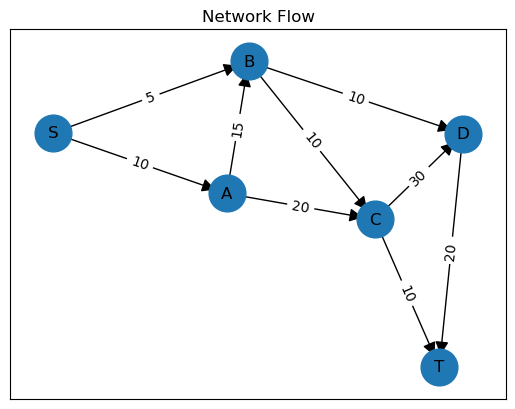

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges with capacities
edges = [
    ('S', 'A', 10), ('S', 'B', 5), ('A', 'B', 15),
    ('A', 'C', 20), ('B', 'C', 10), ('B', 'D', 10),
    ('C', 'D', 30), ('C', 'T', 10), ('D', 'T', 20)
]
for u, v, capacity in edges:
    G.add_edge(u, v, capacity=capacity)

# Calculate the maximum flow
flow_value, flow_dict = nx.maximum_flow(G, 'S', 'T')

# Print the results
print("Maximum flow:", flow_value)
print("Flow along the edges:")
for u in flow_dict:
    for v in flow_dict[u]:
        if flow_dict[u][v] > 0:
            print(f"Flow from {u} to {v}: {flow_dict[u][v]}")

# Visualization of the network
pos = nx.spring_layout(G)  # positions for all nodes
edge_labels = {(u, v): f"{d['capacity']}" for u, v, d in G.edges(data=True)}

nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Network Flow")
plt.show()
